# Gaussian Process Models

In [1]:
### library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from scipy.stats import multivariate_normal
from numpy.linalg import inv

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams['figure.facecolor'] = 'white'
np.set_printoptions(suppress=True)

# Q1 - (c)

Suppose now p = 1. Draw $x_i$ from Unif(0, 1), $i=1, ..., n$ with $n=200$, and then draw $y_i$ from N($\mu(x_i), \sigma^2$) with $\mu(x) = \text{sin}^3(2\pi x^3)$ and $\sigma^2=0.1^2$. Consider fitting the data using the Gaussian process prior on $\mu$ with the squared exponential covariance  

$$ k(x, x') = \tau^2\text{exp}(-\frac{(x-x')^2}{l^2}) $$

Use the Jeffreys prior (log-uniform) for $\sigma^2$. With a few differenct prespecified values of $\tau$ and $l$, obtain teh posterior distribution of $ \tilde{x} = (\mu(\tilde{x_1}), \dots, \mu(\tilde{x_{999}}))$ for the grid points $(\tilde{x_1}, \dots, \tilde{x_{999}}) = (1/1000, \dots, 999/1000)$ by sampling $(\tilde{\mu}, \sigma^2)$ from the joint posterior, i.e.,  
- Draw $\sigma^2$ from $p(\sigma^2 | y)$ using grid sampling (on some suitable range);
- Draw $\tilde{\mu}$ from $p(\tilde{\mu} | y, \sigma^2)$.  

Using the posterior of $\tilde{\mu}$, draw the posterior mean curve and the 95% credible band on (0, 1). Compare the results for different values of $\tau$ and $l$. Do not use Stan or something similar; write your own sampling code (the model does not require MCMC since we fix $\tau$ and $l$, so the use of Stan or similar software should be avoided.)

## 1. Generating data

In [2]:
#################################################################
## Generate X and y
#################################################################
def generate_simulated_data(n, sigma2):
    X = np.random.uniform(0, 1, n)  # Draw xi from Unif(0, 1)
    X = np.sort(X)                  # sort order to plot (Not necessary)
    mu_y = (np.sin(2 * np.pi * (X**3)))**3
    y = np.random.normal(mu_y, np.sqrt(sigma2))

    return X, y

def true_function(x):
    return (np.sin(2 * np.pi * (x**3)))**3

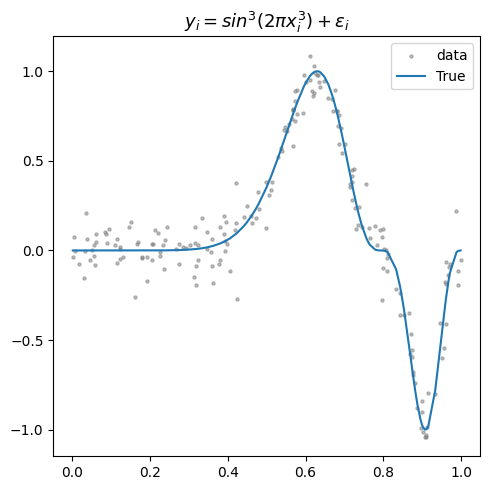

In [3]:
n = 200; m = 999
sigma2 = 0.1 ** 2

## Generate X and y
X, y = generate_simulated_data(n, sigma2)

## Generate new X; X_tilde
X_tilde = np.asarray([i / 1000 for i in range(1, 1000)])
(X_tilde.shape)

## Plot
plt.figure(figsize=(5, 5))
plt.scatter(X, y, label='data', s=5, alpha=0.5, color='gray')
plt.plot(X, true_function(X), label='True')

plt.legend()
plt.title(f'$y_i = sin^3(2 \\pi x_i^3) + \\epsilon_i$', fontsize=13)
plt.tight_layout()
# plt.savefig('Q2_b.png', dpi=125)
plt.show()

## 2. Define Covariance matrix; $K(x, x), K(x, \tilde{x}), K(\tilde{x}, x), K(\tilde{x}, \tilde{x})$
Since we use fixed tau and l, the covariance matrix K(x, x) would not change during iteration.

In [4]:
def cov_function(x1, x2, tau, l):
    """ Sqaured exponential covariance function"""
    k = (tau**2) * np.exp(-(x1 - x2)**2 / l**2)
    
    return k

def cov_matrix(X1, X2, tau, l):
    """ Covariance matrix of cov_function; K(X1, X2) = (( k(X1_i, X2_j) ))_{i, j} """
    K = [cov_function(X1[i], X2, tau, l) for i in range(len(X1))]  # list
    K = np.asarray(K)

    return K

## 3. Calculate $p(\sigma^2 | y)$
### Algorithm
1) Grid sampling for some range, `sigma2_grid`
2) Calculate unnormalize log posterior $log p(\sigma|y)$, `unnorm_log_post`
3) Calculate normalize posterior $p(\sigma|y)$, `norm_post`
4) Draw distribution

Until find appropriate range of $\sigma^2$

### Likelihood
Marginal distribution of MVN;  $p(y|\sigma^2) \sim \text{N}_n(0, K(x, x) + \sigma^2 I_n)$

### Prior
Jeffrey's prior for $\sigma^2$;  $ p(\sigma^2) \propto (\sigma^2)^{-1} $

### log Posterior distribution
$$
\begin{aligned}
p(\sigma^2 | y ) & \propto p(y | \sigma^2) p(\sigma^2) \\
log p(\sigma^2 | y) &  \propto log p(y | \sigma^2) + log p(\sigma^2) \\
& \propto log \text{N}_n(y | 0, K(x, x) + \sigma^2 I_n) - log \sigma^2
\end{aligned}
$$

### Normalized posterior distribution
$$
\begin{aligned}
p(\sigma^2 = \sigma^2_i| y ) & = \frac{p(y | \sigma^2 = \sigma^2_i) p(\sigma^2_i)}{\sum_{k}p(y | \sigma^2 = \sigma^2_k) p(\sigma^2_k)}
\end{aligned}
$$

In [5]:
def posterior_sigma2(y, K_bar_bar, lower, upper):
    """ Calculate posterior of sigma2 given y using grid sampling """

    # 1. Grid sampling for sigma2 to calculate posterior p(sigma^2|y)
    grid = np.arange(lower, upper, 0.01)[1:]
    n_grid = len(grid)

    # 2. log prior
    log_prior = -np.log(grid)  # Jeffrey's prior

    # 3. log likelihood of y 
    log_lik = np.zeros(n_grid)  # container
    mean = np.zeros(n)          # mean vector of y
    for i in range(n_grid):
        cov = K_bar_bar + grid[i] * np.identity(n) + 1e-5 * np.identity(n)     # covariance of y
        log_lik[i] = multivariate_normal.logpdf(y, mean, cov)  # log likelihood

    # 4. Unnormalized log posterior (vector)
    unnorm_log_post = log_lik + log_prior

    # 5. Unnormalized posterior
    unnorm_post = np.exp(unnorm_log_post)

    # 6. Normalize posterior
    norm_post = unnorm_post / sum(unnorm_post)

    return grid, norm_post   

In [8]:
candidate = [[0.5, 0.05],
             [0.5, 0.1],
             [0.5, 0.5],
             [2, 0.1]]

finish (0.5, 0.05)
finish (0.5, 0.1)
finish (0.5, 0.5)
finish (2, 0.1)


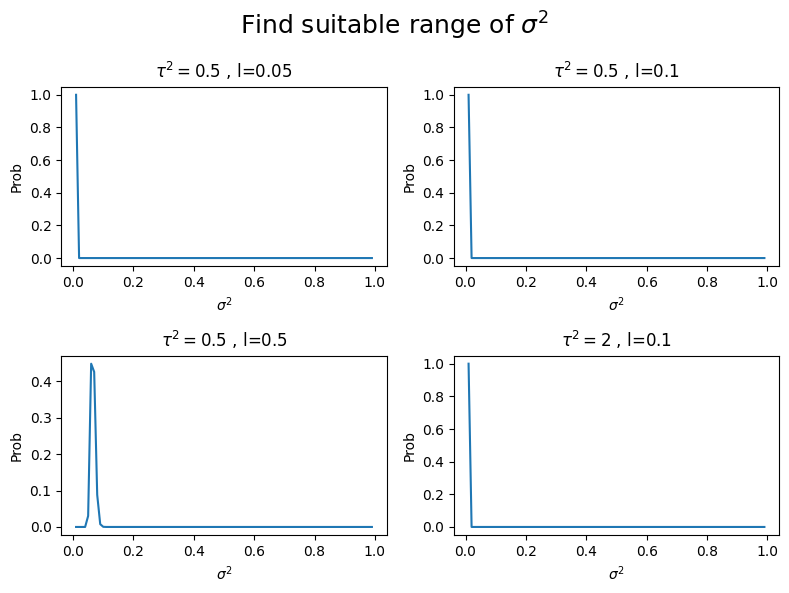

In [9]:
n_plot = 1
plt.figure(figsize=(8, 6))
for tau, l in candidate:
    plt.subplot(2, 2, n_plot)
    K_bar_bar = K_bar_bar = cov_matrix(X, X, tau, l) 
    sigma2_grid, norm_post = posterior_sigma2(y, K_bar_bar, 0, 1)

    plt.plot(sigma2_grid, norm_post)
    plt.title(f'$ \\tau^2={tau}$ , l={l}')
    plt.xlabel(f'$ \sigma^2 $')
    plt.ylabel('Prob')
    n_plot += 1
    print(f'finish {tau, l}')

plt.suptitle('Find suitable range of $\\sigma^2$', size=18)
plt.tight_layout()
plt.show()

# sigma2의 범위가 0.1 < sigma2 < 0.25 적절

## 4. Draw $ \sigma^2$ and $ \tilde{\mu} $

In [13]:
def gaussian_process(y, X, X_tilde, tau=0.5, l=0.05, iter=100):
    n = len(y)
    m = len(X_tilde)

    ####################################################################
    ## 1. Define Covariance matrix
    #  K(x, x), K(x, tilde(x)), K(tilde(x), x), K(tilde(x), tilde(x))
    #  Calculate once when fixed tau and l
    ####################################################################
    K_bar_bar = cov_matrix(X, X, tau, l)                  # K(x, x)
    K_bar_tilde = cov_matrix(X, X_tilde, tau, l)          # K(x, x_tilde)
    K_tilde_bar = cov_matrix(X_tilde, X, tau, l)          # K(x_tilde, x)
    K_tilde_tilde = cov_matrix(X_tilde, X_tilde, tau, l)  # K(x_tilde, x_tilde)

    ####################################################################
    ## 2. Posterior of p(sigma2 | y)
    #  Calculate once when fixed tau and l
    ####################################################################
    sigma2_grid, norm_post = posterior_sigma2(y, K_bar_bar, 0, 0.25)

    ####################################################################
    ## 3. Draw sigma2 and tilde(mu) from posterior (jointly)
    #  1) Draw sigma2 ~ p(sigma2 | y)
    #     p(sigma2 | y) is calculated above and stored as `norm_post`
    #  2) Draw tilde(mu) ~ p(tilde(mu) | y, sigma2)
    #     p(tilde(mu) | y, sigma2) ~ N(mu*, cov*)
    ####################################################################
    # Container for iterations
    sigma2_samples = np.zeros(iter)
    mu_tilde_samples = np.zeros((iter, m))

    # Iterations
    for i in range(iter):

        ### 1) Draw sigma2 from posterior p(sigma^2|y) => (iter, )
        sigma2_samp = np.random.choice(sigma2_grid, p=norm_post)

        ### 2) Draw mu_tilde from posterior p(mu_tilde | y, sigma2_samp) => (iter, m)
        inverse_term = inv(K_bar_bar + sigma2_samp * np.identity(n))  ## K(x, x) + sigma^2 I_n

        ## 2-1) Mean vector of mu_tilde
        mean = K_tilde_bar @ inverse_term @ y  # (m, )
        # print(mean)
        ## 2-2) Cov matrix of mu_tilde
        # Jittering for avoid singular covariance matrix
        epsilon = 1e-5
        # Cov matrix
        cov = K_tilde_tilde - K_tilde_bar @ inverse_term @ K_bar_tilde  + epsilon * np.identity(m)  # (m, m)

        # 2-2) Draw tilda(mu) from posterior (, m)
        mu_tilde_samp = multivariate_normal.rvs(mean, cov)

        ### 3) Save samples
        sigma2_samples[i] = sigma2_samp
        mu_tilde_samples[i] = mu_tilde_samp

        # to check progress
        if i % 20 == 0:
            print(i)

        ### 4) Posterior mean
        posterior_mean = np.mean(mu_tilde_samples, axis=0)
        posterior_interval = np.quantile(mu_tilde_samples, [0.05, 0.95], axis=0)

    return mu_tilde_samples, posterior_mean, posterior_interval

### Draw plot

0
20
40
60
80
finish (0.5, 0.05)
0
20
40
60
80
finish (0.5, 0.1)
0
20
40
60
80
finish (0.5, 0.5)
0
20
40
60
80
finish (2, 0.1)


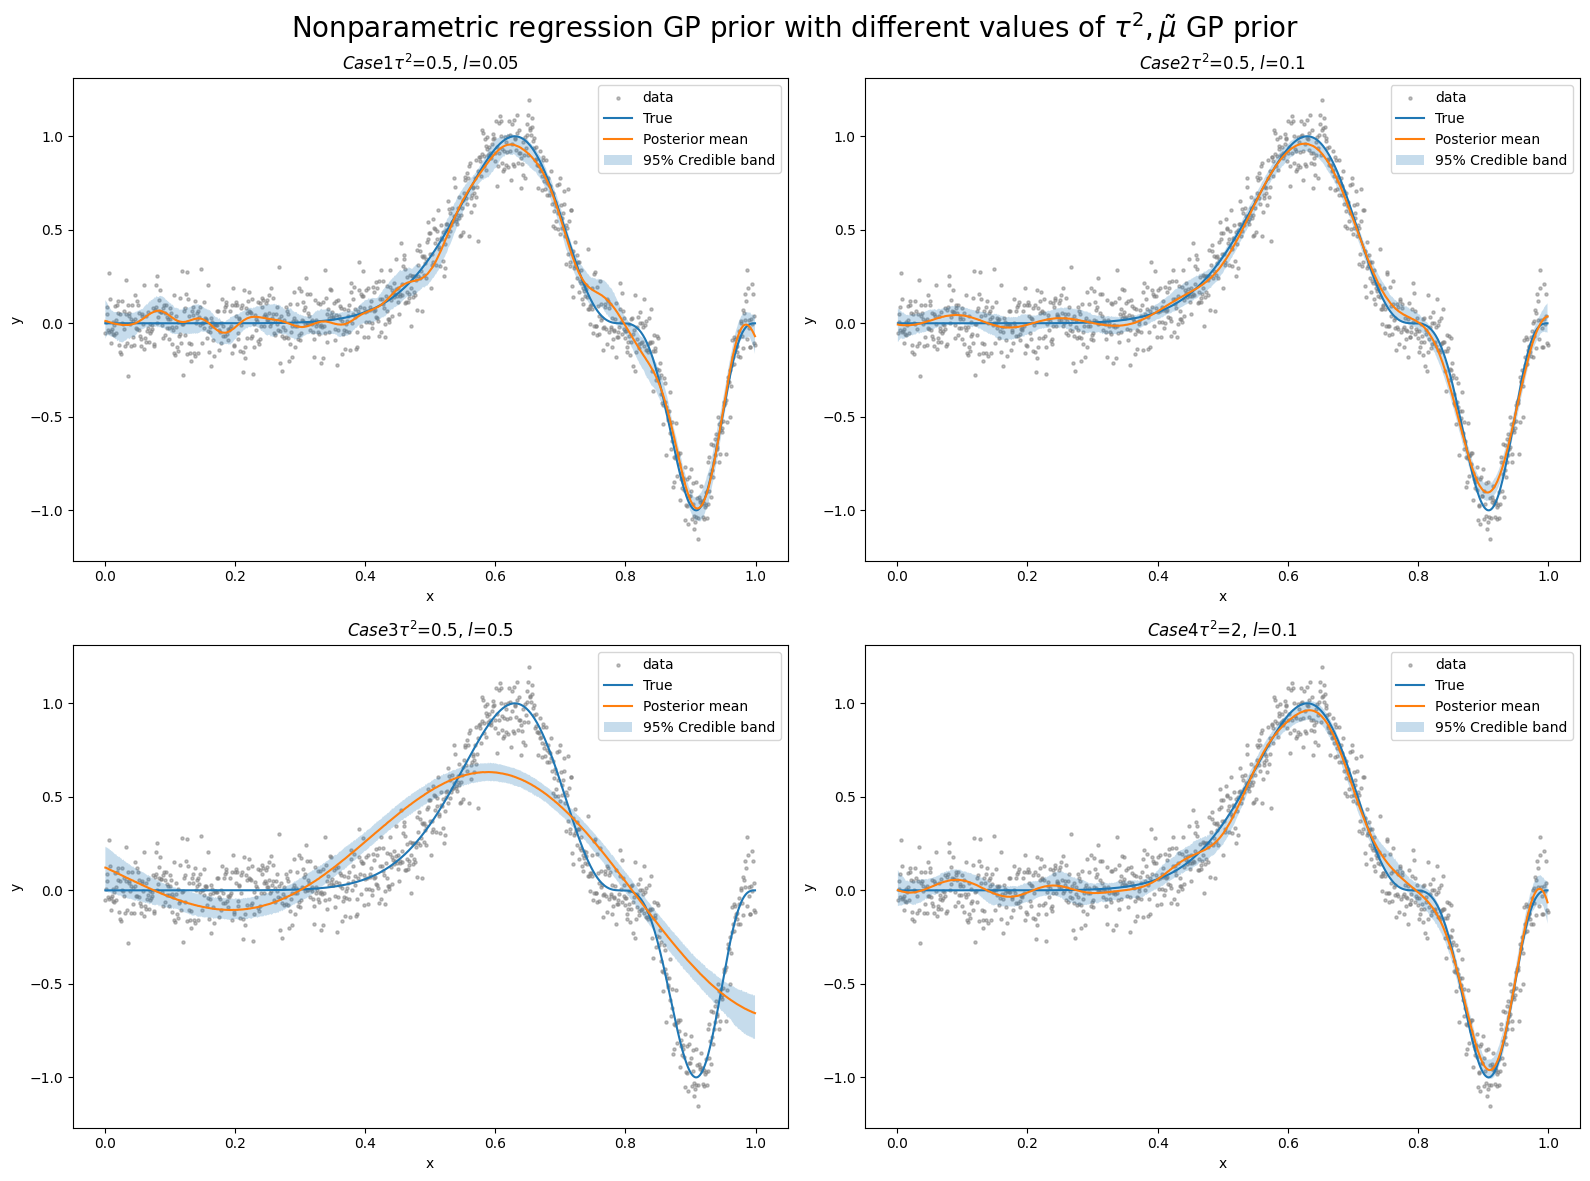

In [15]:
# Get new y for X_tilde
sigma2 = 0.1**2
y_new = np.random.normal((np.sin(2 * np.pi * (X_tilde**3)))**3, np.sqrt(sigma2))

n_plot = 1
plt.figure(figsize=(16, 12))
for i, (tau, l) in enumerate(candidate):
    # Draw sigma2 and tilde(mu)
    mu_tilde_samples, posterior_mean, posterior_interval = gaussian_process(y, X, X_tilde, tau, l, iter=100)
    
    plt.subplot(2, 2, n_plot)
    plt.scatter(X_tilde, y_new, label='data', s=5, alpha=0.5, color='gray')
    plt.plot(X_tilde, true_function(X_tilde), label='True')
    plt.plot(X_tilde, posterior_mean, label='Posterior mean')
    plt.fill_between(X_tilde, posterior_interval[0], posterior_interval[1], alpha=0.25, label='95% Credible band')
    plt.title(f'$ Case{i+1} \\tau^2$={tau}, $l$={l}')
    plt.legend()
    plt.ylabel('y')
    plt.xlabel('x')
    n_plot += 1

    print(f'finish {tau, l}')

plt.suptitle('Nonparametric regression GP prior with different values of $ \\tau^2, \\tilde{\\mu} $ GP prior', size=20)
plt.tight_layout()
# plt.savefig('Q2_b_2.png', dpi=125)
plt.show()